# Setup Environment

## Load Python Modules

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_fscore_support
# import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import os
from data_loader import *
import util
from CNN import *
from copy import deepcopy
%load_ext autoreload
%autoreload 2

## Show NVIDIA GPU

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA H200 (UUID: GPU-9746ad3e-3187-e01a-a32c-475af15ac00d)


## Setup utility

In [4]:
util.setup_logger()

# Load and Process Dataset

## Load Dataset (Embedded split, workaround)

In [5]:
folder_path = "/mnt/dataset"
_all_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
_files = _all_dataset.file_names
train_files, valid_files = train_test_split(_files, test_size=.2)
valid_files, test_files = train_test_split(valid_files, test_size=.5)
train_dataset = deepcopy(_all_dataset)
train_dataset.file_names = train_files
valid_dataset = deepcopy(_all_dataset)
valid_dataset.file_names = valid_files
test_dataset = deepcopy(_all_dataset)
test_dataset.file_names = test_files

logging.info(f"{len(train_dataset)} images for train, {len(valid_dataset)} for validation, and {len(test_dataset)} for testing")

[INFO] 8193 images for train, 1024 for validation, and 1025 for testing


## Load Dataset (Hard split, ideal but not ready)

In [29]:
# folder_path = os.path.join(os.getenv("HOME"), "scratch")
folder_path = "./dataset/small"
valid_dir = "./dataset/validation"
train_dataset = data_loader(os.path.join(folder_path, "feature"), os.path.join(folder_path, "label"))
valid_dataset = data_loader(os.path.join(valid_dir, "feature"), os.path.join(valid_dir, "label"))
# test_dataset  = ImageDataset(os.path.join(folder_path, "test_10p.csv"), use_augmentation=False)

In [16]:
train_dataset.check()

AssertionError: 

# CNN Model

## Create Torch Data Loaders

In [7]:
# train_loader, valid_loader, test_loader = dataset.get_loaders()
train_loader = train_dataset.get_torch_loader()
valid_loader = valid_dataset.get_torch_loader()
test_loader  = test_dataset.get_torch_loader()

## Check CUDA Availability

In [8]:
# "cuda" only when GPUs are available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Debug

In [19]:
path = os.path.join("/mnt/dataset", "feature")
print("Is symlink:", os.path.islink(path))
print("Exists:", os.path.exists(path))
print("Real path:", os.path.realpath(path))

Is symlink: False
Exists: True
Real path: /mnt/dataset/feature


In [21]:
print(os.getcwd())
file_name = "10000-zero-riscy-b-3-c2-u0.85-m1-p6-f1.npy"
# print(os.path.exists(os.path.join("dataset", "small", "feature")))
feature = np.load(os.path.join("./dataset/small", "feature", file_name))
label = np.load(os.path.join("./dataset/small", "label", file_name))
print(transforms.ToTensor()(feature).shape)
feature = np.transpose(feature, (2, 0, 1))
feature = np.expand_dims(feature, axis=0)

print(feature.shape)

model = CNN_FC()
tensor = torch.tensor(feature, dtype=torch.float32)
predict = model(tensor)
X_train, Y_train = train_dataset[0]
print(X_train.shape)
print(X_train.dtype, Y_train.dtype)
# predict = model(X_train)

/home/hice1/ctsai314/DL/Project
torch.Size([24, 256, 256])
(1, 24, 256, 256)
torch.Size([24, 256, 256])
torch.float32 torch.float32


In [22]:
for batch in train_loader:
    x, y = batch
print(x.shape, y.shape)
print(y.dtype)
print(x.dtype)
model = model.to(device)
predict = model(x.to(device))
loss = criterion(predict, y.to(device))

KeyboardInterrupt: 

## Training Setup

In [9]:
_exp_name = "CNN_0702"
# The number of training epochs and patience.
n_epochs = 100
patience = 30 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model, train_losses, valid_losses = try_load_model(_exp_name)
if model == None:
    model = CNN_FC().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)

## Training

In [11]:
train_model(model, optimizer, train_loader, valid_loader, n_epochs=n_epochs, patience=patience,
            criterion=nn.MSELoss(), train_losses = train_losses, valid_losses = valid_losses,
            prefix = _exp_name)

100%|██████████| 32/32 [00:06<00:00,  5.31it/s]


[ Valid | 001/100 ] loss = 0.011926
[ Valid | 001/100 ] loss = 0.011926 -> best


100%|██████████| 257/257 [01:35<00:00,  2.70it/s]


[ Train | 010/100 ] loss = 0.0084772


100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


[ Valid | 010/100 ] loss = 0.016113
[ Valid | 010/100 ] loss = 0.016113
Epoch 10 duration: 101.24 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 011/100 ] loss = 0.0086427


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


[ Valid | 011/100 ] loss = 0.012065
[ Valid | 011/100 ] loss = 0.012065
Epoch 11 duration: 72.29 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 012/100 ] loss = 0.0082109


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 012/100 ] loss = 0.023025
[ Valid | 012/100 ] loss = 0.023025
Epoch 12 duration: 72.23 seconds


100%|██████████| 257/257 [01:06<00:00,  3.84it/s]


[ Train | 013/100 ] loss = 0.0085279


100%|██████████| 32/32 [00:05<00:00,  5.36it/s]


[ Valid | 013/100 ] loss = 0.037898
[ Valid | 013/100 ] loss = 0.037898
Epoch 13 duration: 72.85 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 014/100 ] loss = 0.0086484


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[ Valid | 014/100 ] loss = 0.021543
[ Valid | 014/100 ] loss = 0.021543
Epoch 14 duration: 72.06 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 015/100 ] loss = 0.0082593


100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


[ Valid | 015/100 ] loss = 0.012968
[ Valid | 015/100 ] loss = 0.012968
Epoch 15 duration: 72.21 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 016/100 ] loss = 0.0082052


100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


[ Valid | 016/100 ] loss = 0.008704
[ Valid | 016/100 ] loss = 0.008704 -> best
Epoch 16 duration: 72.15 seconds
Best model found at epoch 15, saving model


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 017/100 ] loss = 0.0088065


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


[ Valid | 017/100 ] loss = 0.010006
[ Valid | 017/100 ] loss = 0.010006
Epoch 17 duration: 72.10 seconds


100%|██████████| 257/257 [01:06<00:00,  3.89it/s]


[ Train | 018/100 ] loss = 0.0081324


100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


[ Valid | 018/100 ] loss = 0.016414
[ Valid | 018/100 ] loss = 0.016414
Epoch 18 duration: 71.92 seconds


100%|██████████| 257/257 [01:06<00:00,  3.89it/s]


[ Train | 019/100 ] loss = 0.0080475


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


[ Valid | 019/100 ] loss = 0.05326
[ Valid | 019/100 ] loss = 0.05326
Epoch 19 duration: 72.00 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 020/100 ] loss = 0.0081241


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


[ Valid | 020/100 ] loss = 0.0081481
[ Valid | 020/100 ] loss = 0.0081481 -> best
Epoch 20 duration: 72.09 seconds
Best model found at epoch 19, saving model


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 021/100 ] loss = 0.0079527


100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


[ Valid | 021/100 ] loss = 0.018553
[ Valid | 021/100 ] loss = 0.018553
Epoch 21 duration: 72.31 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 022/100 ] loss = 0.0077974


100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


[ Valid | 022/100 ] loss = 0.025217
[ Valid | 022/100 ] loss = 0.025217
Epoch 22 duration: 72.21 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 023/100 ] loss = 0.007677


100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


[ Valid | 023/100 ] loss = 0.0093475
[ Valid | 023/100 ] loss = 0.0093475
Epoch 23 duration: 72.06 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 024/100 ] loss = 0.007673


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 024/100 ] loss = 0.010306
[ Valid | 024/100 ] loss = 0.010306
Epoch 24 duration: 72.22 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 025/100 ] loss = 0.0083435


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 025/100 ] loss = 0.027842
[ Valid | 025/100 ] loss = 0.027842
Epoch 25 duration: 72.12 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 026/100 ] loss = 0.0078919


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[ Valid | 026/100 ] loss = 0.062213
[ Valid | 026/100 ] loss = 0.062213
Epoch 26 duration: 72.16 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 027/100 ] loss = 0.0080917


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


[ Valid | 027/100 ] loss = 0.028197
[ Valid | 027/100 ] loss = 0.028197
Epoch 27 duration: 72.10 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 028/100 ] loss = 0.0078882


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


[ Valid | 028/100 ] loss = 0.0084139
[ Valid | 028/100 ] loss = 0.0084139
Epoch 28 duration: 72.17 seconds


100%|██████████| 257/257 [01:05<00:00,  3.89it/s]


[ Train | 029/100 ] loss = 0.0078245


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


[ Valid | 029/100 ] loss = 0.033272
[ Valid | 029/100 ] loss = 0.033272
Epoch 29 duration: 71.95 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 030/100 ] loss = 0.0078946


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 030/100 ] loss = 0.0078831
[ Valid | 030/100 ] loss = 0.0078831 -> best
Epoch 30 duration: 72.25 seconds
Best model found at epoch 29, saving model


100%|██████████| 257/257 [01:06<00:00,  3.86it/s]


[ Train | 031/100 ] loss = 0.0077347


100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


[ Valid | 031/100 ] loss = 0.0097275
[ Valid | 031/100 ] loss = 0.0097275
Epoch 31 duration: 72.50 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 032/100 ] loss = 0.0077625


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 032/100 ] loss = 0.013363
[ Valid | 032/100 ] loss = 0.013363
Epoch 32 duration: 72.33 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 033/100 ] loss = 0.0078038


100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


[ Valid | 033/100 ] loss = 0.14255
[ Valid | 033/100 ] loss = 0.14255
Epoch 33 duration: 72.19 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 034/100 ] loss = 0.0078826


100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


[ Valid | 034/100 ] loss = 0.017753
[ Valid | 034/100 ] loss = 0.017753
Epoch 34 duration: 72.08 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 035/100 ] loss = 0.0083729


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 035/100 ] loss = 0.012875
[ Valid | 035/100 ] loss = 0.012875
Epoch 35 duration: 72.25 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 036/100 ] loss = 0.007938


100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


[ Valid | 036/100 ] loss = 0.010878
[ Valid | 036/100 ] loss = 0.010878
Epoch 36 duration: 72.09 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 037/100 ] loss = 0.0077907


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 037/100 ] loss = 0.010489
[ Valid | 037/100 ] loss = 0.010489
Epoch 37 duration: 72.26 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 038/100 ] loss = 0.0076864


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 038/100 ] loss = 0.13766
[ Valid | 038/100 ] loss = 0.13766
Epoch 38 duration: 72.23 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 039/100 ] loss = 0.0076916


100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


[ Valid | 039/100 ] loss = 0.0082706
[ Valid | 039/100 ] loss = 0.0082706
Epoch 39 duration: 72.43 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 040/100 ] loss = 0.007698


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


[ Valid | 040/100 ] loss = 0.065284
[ Valid | 040/100 ] loss = 0.065284
Epoch 40 duration: 72.24 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 041/100 ] loss = 0.0077548


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


[ Valid | 041/100 ] loss = 0.05828
[ Valid | 041/100 ] loss = 0.05828
Epoch 41 duration: 72.25 seconds


100%|██████████| 257/257 [01:08<00:00,  3.76it/s]


[ Train | 042/100 ] loss = 0.0083499


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 042/100 ] loss = 0.008803
[ Valid | 042/100 ] loss = 0.008803
Epoch 42 duration: 74.28 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 043/100 ] loss = 0.007914


100%|██████████| 32/32 [00:05<00:00,  5.34it/s]


[ Valid | 043/100 ] loss = 0.04291
[ Valid | 043/100 ] loss = 0.04291
Epoch 43 duration: 72.26 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 044/100 ] loss = 0.0080794


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


[ Valid | 044/100 ] loss = 0.019242
[ Valid | 044/100 ] loss = 0.019242
Epoch 44 duration: 72.33 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 045/100 ] loss = 0.007806


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[ Valid | 045/100 ] loss = 0.081338
[ Valid | 045/100 ] loss = 0.081338
Epoch 45 duration: 72.09 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 046/100 ] loss = 0.0076731


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


[ Valid | 046/100 ] loss = 0.0095503
[ Valid | 046/100 ] loss = 0.0095503
Epoch 46 duration: 72.37 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 047/100 ] loss = 0.0077391


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 047/100 ] loss = 0.010624
[ Valid | 047/100 ] loss = 0.010624
Epoch 47 duration: 72.24 seconds


100%|██████████| 257/257 [01:06<00:00,  3.85it/s]


[ Train | 048/100 ] loss = 0.0077137


100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


[ Valid | 048/100 ] loss = 0.0094745
[ Valid | 048/100 ] loss = 0.0094745
Epoch 48 duration: 72.53 seconds


100%|██████████| 257/257 [01:06<00:00,  3.89it/s]


[ Train | 049/100 ] loss = 0.0077395


100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


[ Valid | 049/100 ] loss = 0.0091796
[ Valid | 049/100 ] loss = 0.0091796
Epoch 49 duration: 71.89 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 050/100 ] loss = 0.0075944


100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


[ Valid | 050/100 ] loss = 0.0086055
[ Valid | 050/100 ] loss = 0.0086055
Epoch 50 duration: 72.34 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 051/100 ] loss = 0.0076133


100%|██████████| 32/32 [00:05<00:00,  5.44it/s]


[ Valid | 051/100 ] loss = 0.02188
[ Valid | 051/100 ] loss = 0.02188
Epoch 51 duration: 72.31 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 052/100 ] loss = 0.007756


100%|██████████| 32/32 [00:05<00:00,  5.37it/s]


[ Valid | 052/100 ] loss = 0.016504
[ Valid | 052/100 ] loss = 0.016504
Epoch 52 duration: 72.26 seconds


100%|██████████| 257/257 [01:06<00:00,  3.86it/s]


[ Train | 053/100 ] loss = 0.0079176


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


[ Valid | 053/100 ] loss = 0.0093976
[ Valid | 053/100 ] loss = 0.0093976
Epoch 53 duration: 72.45 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 054/100 ] loss = 0.0076517


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


[ Valid | 054/100 ] loss = 0.011021
[ Valid | 054/100 ] loss = 0.011021
Epoch 54 duration: 72.10 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 055/100 ] loss = 0.0076996


100%|██████████| 32/32 [00:05<00:00,  5.42it/s]


[ Valid | 055/100 ] loss = 0.012593
[ Valid | 055/100 ] loss = 0.012593
Epoch 55 duration: 72.07 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 056/100 ] loss = 0.0082492


100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


[ Valid | 056/100 ] loss = 0.0079623
[ Valid | 056/100 ] loss = 0.0079623
Epoch 56 duration: 72.01 seconds


100%|██████████| 257/257 [01:06<00:00,  3.89it/s]


[ Train | 057/100 ] loss = 0.0079437


100%|██████████| 32/32 [00:05<00:00,  5.35it/s]


[ Valid | 057/100 ] loss = 0.011174
[ Valid | 057/100 ] loss = 0.011174
Epoch 57 duration: 72.07 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 058/100 ] loss = 0.0077574


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


[ Valid | 058/100 ] loss = 1.2597
[ Valid | 058/100 ] loss = 1.2597
Epoch 58 duration: 72.18 seconds


100%|██████████| 257/257 [01:06<00:00,  3.87it/s]


[ Train | 059/100 ] loss = 0.0081466


100%|██████████| 32/32 [00:05<00:00,  5.36it/s]


[ Valid | 059/100 ] loss = 0.0093461
[ Valid | 059/100 ] loss = 0.0093461
Epoch 59 duration: 72.47 seconds


100%|██████████| 257/257 [01:06<00:00,  3.88it/s]


[ Train | 060/100 ] loss = 0.0077867


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


[ Valid | 060/100 ] loss = 0.038684
[ Valid | 060/100 ] loss = 0.038684
Epoch 60 duration: 72.18 seconds


100%|██████████| 257/257 [01:06<00:00,  3.85it/s]


[ Train | 061/100 ] loss = 0.0077395


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]

[ Valid | 061/100 ] loss = 0.016225
[ Valid | 061/100 ] loss = 0.016225
Epoch 61 duration: 72.71 seconds
No improvment 30 consecutive epochs, early stopping


([0.05767175343235527,
  0.010511989270405779,
  0.009606498666832419,
  0.0095783099785795,
  0.009486487740469582,
  0.009698712069483235,
  0.009319683091156909,
  0.009003059692130014,
  0.009126045367887048,
  0.008477197766144568,
  0.008642703912615892,
  0.008210854264200894,
  0.008527858347671852,
  0.008648411524826335,
  0.008259254610999432,
  0.008205224540635422,
  0.008806457576352799,
  0.008132440945793103,
  0.00804754219775302,
  0.008124067685440009,
  0.007952719606125749,
  0.0077974054969644265,
  0.007677029194998834,
  0.0076729554777189455,
  0.008343497383614807,
  0.007891860957246578,
  0.0080917096472117,
  0.007888209727023827,
  0.007824456819300522,
  0.007894649675862451,
  0.007734748128990023,
  0.0077624897316736,
  0.007803836554752713,
  0.007882580041508498,
  0.008372890319066404,
  0.007937974506691968,
  0.007790719524953616,
  0.007686427270754418,
  0.007691564585593192,
  0.007698011100799541,
  0.007754790286827064,
  0.00834991528148897,

# Testing the Model

## Load the model

[INFO] Model loaded from CNN_0702_best.ckpt, loss loaded from CNN_0702_loss.pkl, trained for 60 epochs


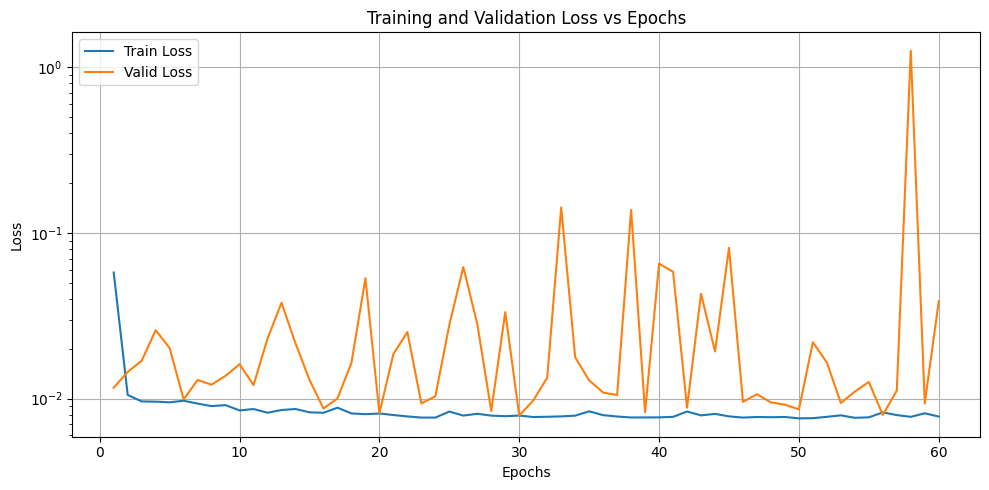

In [12]:
# model = load_model(f"{_exp_name}_best.ckpt")
model, train_losses, valid_losses = try_load_model(_exp_name)
plot_losses(train_losses, valid_losses)

## Evaluation

In [ ]:
# NOT READY.
evaluate_model(model, test_loader)